In [26]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import matplotlib.ticker as ticker

In following computations we use the Earth-Moon rotating coordinate frame with origin in Earth-Moon baricenter. The distance from $L_2$ to the origin is given by the positive solution of the following equation:
$$\gamma - (1 - \mu)/(\gamma + \mu)^2 - \mu/(\gamma - 1 + \mu)^2 = 0,$$

$$\mu = \frac{M_s}{M_p + M_s},$$
where $M_p$ and $M_s$ denote the masses of the primary and the secondary (smaller of the two primaries) body, respectively.

The equations of motion in the barycentric reference frame (nondimentionlized):
\begin{align}
\ddot{x} - 2\dot{y} - x &= - \frac{(1-\mu)(x+\mu)}{r_p^3} - \frac{\mu(x-(1-\mu))}{r_s^3}, \\
\ddot{y} + 2\dot{x} - y &= - \frac{(1-\mu)y}{r_p^3} - \frac{\mu y}{r_s^3}, \\
\ddot{z} &= - \frac{(1-\mu)z}{r_p^3} - \frac{\mu z}{r_s^3},
\end{align}
where
$$r_p = \sqrt{(x+\mu)^2 + y^2 + z^2}, \quad r_s = \sqrt{(x-(1-\mu))^2 + y^2 + z^2}$$, according to [1]

The distance between the two primaries is 1, the reference frame origin is based in the system's baricenter.
The conversion from units of distance, velocity, and time in the unprimed, normalized system to the primed, dimensionalized system is:
\begin{align}
d' &= L\cdot d, \\
s' &= V\cdot s, \\
t' &= \frac{T}{2\pi}t,
\end{align}
where where $L$ is the distance between the centers of $M_P$ and $M_S$, $V$ is the orbital velocity of $M_S$, $T$ is the orbital period of $M_P$ and $M_S$.

The following constants (for the Earth-Moon system) are used below:
    $$\mu = 1.215\cdot10^{-2},  [1], [3]$$
    $$T = 2.361\cdot10^{6},  [1]$$
    $$L_2 = 1.556825,  [2]$$


In the last frame we check the behaviour of energy relative mistake: as you can see, computing deffects are negligible. 

[1] Dynamical Systems, the Three-Body Problem and Space Mission Design, http://www.cds.caltech.edu/~marsden/volume/missiondesign/KoLoMaRo_DMissionBk.pdf

[2] Libration point orbits and manifolds: design and station-keeping, 
http://www.mathnet.ru/links/d214da1304703fe544f855e9ed635481/ipmp1942.pdf

[3] Astronomical constants,
https://asa.hmnao.com/static/files/2021/Astronomical_Constants_2021.pdf


In [27]:
class Characteristics(object):
    pass

param = Characteristics()
param.mu = 0.01215

time = Characteristics()
time.begin = 0
time.end = 20
time.dt = 0.05

## Following equation computes the x-coordinate of L2 in reference frame for Earth-Moon system(with origin in the barycenter). 

In [28]:
def get_L2_quintic(mu):
    def quintic_L2(x):
        return x - (1 - mu)/(x + mu)**2 - mu/(x - 1 + mu)**2
        
    root = fsolve(quintic_L2, 1 + mu, xtol=1e-10)
    return root[0] 

get_L2_quintic(param.mu)

1.1556799130947353

## Equation from [1]

In [29]:
def get_L2_quintic_original(mu):
    def quintic_L2_original(x):
        return x**5 + (3 - mu)*x**4 + (3 - 2*mu)*x**3 - mu*x**2 - 2*mu*x - mu
        
    root = fsolve(quintic_L2_original, 1 + mu, xtol=1e-10)
    return root[0] 

get_L2_quintic_original(param.mu) + 1 - param.mu  # x is the distance to a smaller primary, therefore
                                         # we have to add (1 - mu) to get an L2 coordinate

1.1556799130947353

In [30]:
def ode(t, r, param):
    x = r[0]
    y = r[1]
    z = r[2]
    v_x = r[3]
    v_y = r[4]
    v_z = r[5]
    
    r10 = [x + param.mu, y, z]
    r20 = [x + param.mu - 1, y, z]
    r1 = np.linalg.norm(r10)
    r2 = np.linalg.norm(r20)
    
    dxdt = np.zeros(6)
    dxdt[:3] = [v_x, v_y, v_z]
    dxdt[3] = 2 * v_y + x - (1 - param.mu)*(x + param.mu)/(r1**3) - param.mu*(x - 1 + param.mu)/(r2**3)
    dxdt[4] = -2 * v_x + y - (1 - param.mu)*y/(r1**3) - param.mu*y/(r2**3)
    dxdt[5] = -(1 - param.mu)*z/(r1**3) - param.mu*z/(r2**3)

    return dxdt
    
rP_0 = [get_L2_quintic(param.mu), 0, 0]
vP_0 = [0, 0, 0]
r_0 = rP_0 + vP_0

t_sol = np.arange(time.begin, time.end, time.dt)

solution = sci.solve_ivp(lambda t, r: ode(t, r, param), (time.begin, time.end), r_0, t_eval = t_sol, atol = 1e-10, rtol = 1e-10)

r_sol = solution.y.T

## On the next graph we are plotting the result of computing the equations for the start-up conditions, given in the previous frame 

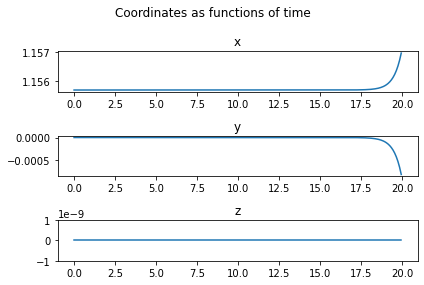

In [31]:
fig, axs = plt.subplots(3)
fig.suptitle('Coordinates as functions of time')
axs[0].plot(t_sol, r_sol[:, 0])
axs[0].set_title('x')
axs[1].plot(t_sol, r_sol[:, 1])
axs[1].set_title('y')
axs[2].plot(t_sol, r_sol[:, 2])
axs[2].set_title('z')

plt.ylim(-1e-9, 1e-9)
plt.tight_layout()

## Here we plot the velocity components on axes x, y, z.

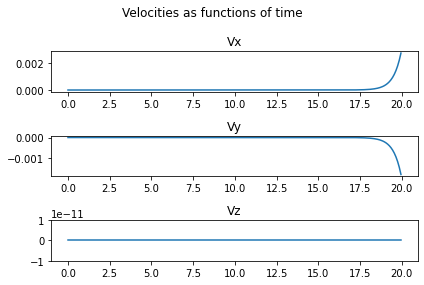

In [32]:
fig, axs = plt.subplots(3)
fig.suptitle('Velocities as functions of time')
axs[0].plot(t_sol, r_sol[:, 3])
axs[0].set_title('Vx')
axs[1].plot(t_sol, r_sol[:, 4])
axs[1].set_title('Vy')
axs[2].plot(t_sol, r_sol[:, 5])
axs[2].set_title('Vz')

plt.ylim(-1e-11, 1e-11)
plt.tight_layout()

## Jacobi Integral

<font size="3">The equations of motion admit the first integral known as Jacobi integral, which is given by:</font>

### $C = v_x^2 + v_y^2 + v_z^2 - 2U.$

<font size="3"> The plot below shows the relative error of $C$.</font>

(-1e-14, 1e-14)

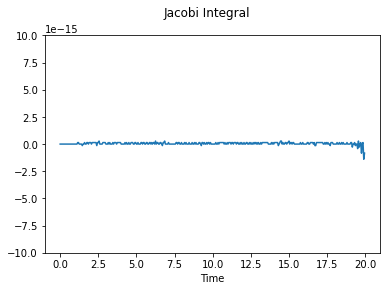

In [33]:
U = np.zeros(np.size(t_sol))
Relative = np.zeros(np.size(t_sol))

for i in range(np.size(t_sol)):
    x = r_sol[i][0]
    y = r_sol[i][1]
    z = r_sol[i][2]
    v_x = r_sol[i][3]
    v_y = r_sol[i][4]
    v_z = r_sol[i][5]
    r10 = [x + param.mu, y, z]
    r20 = [x + param.mu - 1, y, z]
    r1 = np.linalg.norm(r10)
    r2 = np.linalg.norm(r20)
    U[i] = -0.5*((1 - param.mu)*(r1**2) + param.mu*(r2**2)) - (1 - param.mu)/r1 - param.mu/r2
    C = -(v_x**2 + v_y**2 + v_z**2) - 2*U[i]
    if i == 0:
        C_0 = C
    Relative[i] = (C-C_0)/C_0
    
    
plt.plot(t_sol, Relative)
plt.suptitle('Jacobi Integral')
plt.xlabel('Time')
plt.ticklabel_format(useOffset = False)
plt.ylim(-1e-14, 1e-14)